<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 32.1 MB/s 
     |████████████████████████████████| 346 kB 60.5 MB/s 
     |████████████████████████████████| 4.2 MB 58.3 MB/s 
     |████████████████████████████████| 197 kB 66.7 MB/s 
     |████████████████████████████████| 1.2 MB 54.5 MB/s 
     |████████████████████████████████| 59 kB 8.7 MB/s 
     |████████████████████████████████| 212 kB 32.5 MB/s 
     |████████████████████████████████| 140 kB 74.6 MB/s 
     |████████████████████████████████| 1.1 MB 59.5 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 64.7 MB/s 
     |████████████████████████████████| 127 kB 68.6 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 60.6 MB/s 
     |████████████████████████████████| 271 kB 71.8 MB/s 
     |████████████████████████████████| 6.6 MB 54.0 MB/s 
ERROR: pip's dependenc

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
#Read Data
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
#Turn data into DataBlock
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels']) #Note: if you plan on exporting your learner, lambdas are not best option as they aren't compatible with serealization
dsets = dblock.datasets(df) #Get train and test sets
dsets.train[0] #See first item in training set

('008663.jpg', 'car person')

In [5]:
#Define a better get x/y
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
#Tell data block type of data it's loading (images and multicategory)
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0] #We can see we now have an image obj and a binary list of categories (one-hot encoding)

(PILImage mode=RGB size=500x332,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [6]:
#Check what labels are present
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['aeroplane']

In [7]:
#Data came with Validation data so we don't want to use a random splitter
#We will make our own
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid
#Remake our DBlock with new splitter
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

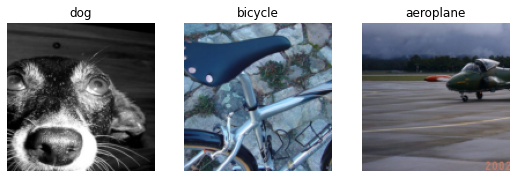

In [8]:
#Now must make sure all data is same size for our DataLoader
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df) #Get DataLoader
dls.show_batch(nrows=1, ncols=3)

In [9]:
#Creating a Learner
learn = vision_learner(dls, resnet18)
#See how many activations our learner has
x,y = dls.train.one_batch() #Get a mini batch to use
learn.model.cuda()          #Put model on GPU
activs = learn.model(x)     #Get our activations from our model by passing our minibatch
activs.shape #See it's shape, makes sense 64 items in batch 20 possible labels

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([64, 20])

##Softmax assumes all probabilities add to 1 which may not be the case with ,ultipple items in an image - or no items at all. nll_loss returns the value of just 1 activation - also unhelpful in this case. However, the binary_cross_entropy function provides what we need (mnist_loss and log). With PyTorch will work on multiple elements.

In [10]:
#We will use BCEWithLogitsLoss since we have one-hot encoded targets
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0475, device='cuda:0', grad_fn=<AliasBackward0>)

Our Metrics also cahnge. Accuracy predicts only the highest probablities of numbers between 0 and 1. So we must set a threshold that will decide which values are considered "in the picture" and which are not

In [11]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

In [12]:
#We can now train our model
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941580,0.682664,0.238865,00:41
1,0.826538,0.576051,0.283486,00:29
2,0.603867,0.202176,0.822311,00:46
3,0.362905,0.124218,0.938805,00:41


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133181,0.117383,0.947351,00:41
1,0.119822,0.108537,0.949960,00:42
2,0.098454,0.104536,0.950757,00:32


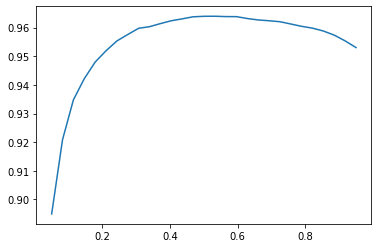

In [13]:
#We can find the best threshold through iteration
preds, targs = learn.get_preds()
xs = torch.linspace(0.05, .95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

###Image Regression

In [14]:
#Here we will make a key point model - finding a specific location in the image
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/23.obj'),Path('/root/.fastai/data/biwi_head_pose/17.obj'),Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/15.obj'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/03'),Path('/root/.fastai/data/biwi_head_pose/21')...]

In [15]:
(path/'01').ls() #Each numbered directory is a specific person
#Inside there are different frames each with a _rgb.jpg and _pose.txt

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00497_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00111_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00498_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00110_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00311_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00032_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00058_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00101_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00023_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00310_rgb.jpg')...]

In [16]:
#Get all image files
img_files = get_image_files(path)
#Func to get corresponding pose file
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0]) #Make sure it works

Path('/root/.fastai/data/biwi_head_pose/24/frame_00111_pose.txt')

In [17]:
#Visualize image 1
im = PILImage.create(img_files[0])
im.shape

(480, 640)

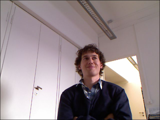

In [18]:
im.to_thumb(160)

In [19]:
#Define our get center function
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])
get_ctr(img_files[0]) #Test

tensor([382.9565, 240.3137])

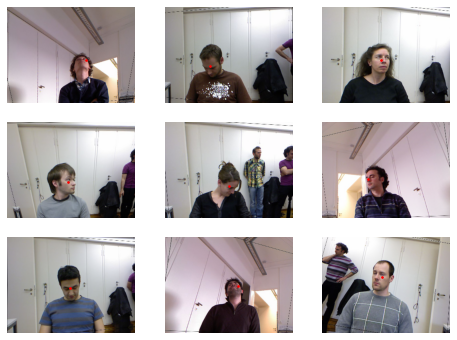

In [20]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock), #PointBlock tells fastai label is a coordinate that should also be affected by augmentation
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'), #Make an individual the validation set so we dont just memorize faces
    batch_tfms = [*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)

dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

SuggestedLRs(valley=0.0014454397605732083)

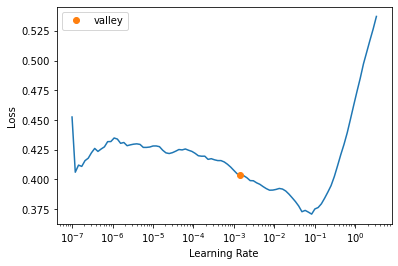

In [21]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))
learn.lr_find() #Find a good learning rate

epoch,train_loss,valid_loss,time
0,0.044024,0.010019,02:15
1,0.006809,0.002733,02:05
2,0.003240,0.003041,02:05
3,0.002358,0.000215,02:04
4,0.001574,0.000173,02:04


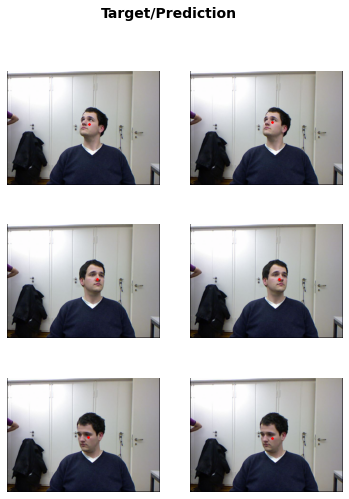

In [22]:
lr = 2e-2
learn.fit_one_cycle(5, lr)
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))